In [1]:
%matplotlib inline
import pickle
import networkx as nx
import community
import matplotlib.pyplot as plt

In [3]:
#G=pickle.load(open('subdata/downsample_syl_2_meta_100_01.pkl','r'))
import time
start_time = time.time()
pfile='subdata/downsample_syl_2_meta_100_01.pkl'
G = nx.read_gpickle(pfile) #--- 7.13846588135 seconds ---
#G=pickle.load(open('subdata/downsample_syl_2_meta_100_01.pkl','r'))#--- 33.3855979443 seconds ---
print("--- %s seconds ---" % (time.time() - start_time))


--- 7.06548690796 seconds ---


In [4]:
len(G.edges())

783661

## todos
1. loading pickled graph is very slow due to its big size. we can try to reduce the size. One thing is to reduce the digits.
2. next we're trying to filter the edges by weight. what is a good threshold? lots of experiments with different parameters.maybe we can get a dist distribution (weight) first.

# weights distribution and thresholding

In [37]:
#all weights, plot distribution
all_weights=[d['weight'] for (u,v,d) in G.edges(data=True)]

(0, 50)

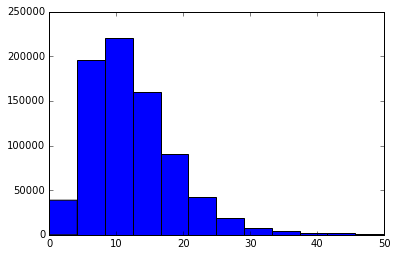

In [109]:
plt.hist(all_weights,bins=20)
plt.xlim(0,50)
#plt.ylim(0,550)

# threshold

this example shows how to do simple dist(weight) thresholding and derive a unweighted network.
https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html

next steps for thresholding and experimentation with randomized network: dist_threshold_plans.ipynb

In [53]:
#these are basically all distance 0, but has some overflow.we should ignore them as they are just distance (i,i), 
#that's why when you visualize the graph, there is no edges between nodes
[i for i in all_weights if i<0.1]

[1.4600096599955427e-07,
 2.384185791015625e-07,
 5.960464477539063e-08,
 2.384185791015625e-07,
 2.9200193199910854e-07,
 1.6858739404357614e-07,
 9.5367431640625e-07,
 1.1920928955078125e-07,
 1.6858739404357614e-07,
 2.0647654623614278e-07,
 2.384185791015625e-07,
 2.9200193199910854e-07,
 2.384185791015625e-07,
 1.6858739404357614e-07,
 2.384185791015625e-07,
 4.1295309247228556e-07,
 2.0647654623614278e-07,
 2.384185791015625e-07,
 2.384185791015625e-07,
 1.4600096599955427e-07,
 2.384185791015625e-07,
 1.6858739404357614e-07,
 4.1295309247228556e-07,
 3.371747880871523e-07,
 1.6858739404357614e-07,
 1.1920928955078125e-07,
 3.371747880871523e-07,
 2.384185791015625e-07,
 1.3328003749250113e-07,
 2.384185791015625e-07,
 1.6858739404357614e-07,
 1.6858739404357614e-07,
 2.384185791015625e-07,
 1.6858739404357614e-07,
 2.384185791015625e-07,
 2.9200193199910854e-07,
 2.9200193199910854e-07,
 2.384185791015625e-07,
 4.76837158203125e-07,
 2.384185791015625e-07,
 1.4600096599955427e-0

701


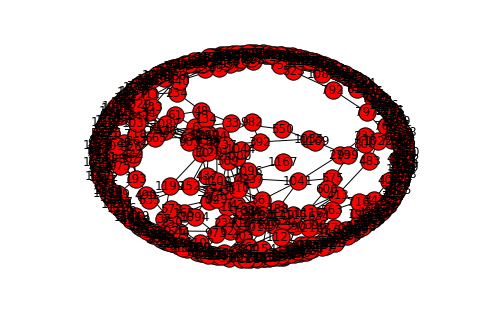

In [121]:
#selecting edges with weight thresholds
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1.5 and d['weight']>0.1]
print len(esmall)
H=nx.Graph(esmall)
nx.draw(H,with_labels=True)

In [132]:
#clustering coeffeicient

#clustering coef for average of all nodes
print 'average cc:'+str(nx.average_clustering(H))
num_zero_cc=0
cc=nx.clustering(H)
print len(cc.keys())
for k in cc:
    if cc[k]==0:
        num_zero_cc+=1
print 'number of CC=0:',num_zero_cc 
print 'total nodes:', len(H.edges())

average cc:0.222117611814
465
number of CC=0: 292
total nodes: 701


## Now

Now you have this code for thresholding and converting to unweighted network. But eventually, visualization of graph is not useful. We could intuitively plot these nodes that are connected and see their TS shapes. But that would ideally but done after we've decided on a threshold and performed community detection. we want to do these things with least amount of relying on intuition and judgment, but we want to do it automated and with clear evaluations.(these steps, even community detection, are mostly one line codes anyway.)

now the question is the evaluation also. We have in the network, all nodes belong to the same tone n-gram category. Therefore, the evlauation here is purely on shape. 

# experimenting with different dist threshold and randomized network

1. have the weighted network fully connected F.
2. apply dist threshold T and delete edges whose weights (distance) is greater than threshold.
3. convert the resulting network to unweighted G.
4. in the unweighted network, compute clustering coefficient(CC).
5. swap random edges of this network (while preserving degree distribution) and derive randomized network GR.
6. compute CC for GR.
7. compute the difference between GR and G's CC. 
8. repeat previous steps with a different T, and then observe when CC_GR and CC_G is maximally different.


## Sankalp's code for randomization

https://github.com/sankalpg/Library_PythonNew/blob/941c28801071602c3fc7cb3fed02d4b21cb29086/networkAnalysis/clusteringCoffGen.cpp

# Swapping edges (no.5 above)

it is done according to M.Newman,The structure and function of complex networks:

edge swaps of the form {(v1,w1), (v2,w2)} → {(v1, v2), (w1,w2)} for the case of fixed degree sequence, where (v1,w1) denotes an edge from vertex v1 to vertex w1. 

In code, here are the steps:

0. have a unweighted network G;
1. find two nodes that are not connected, N1,N2;
2. for N1: get its degree D;
3. generate a random number R in [1,D]
4. get the neighbor node of N1, N1R=N1[R] so that NR1 is not connected to N2;
5. repeat 2-4 steps to get N2R, which is a neighbor of N2 and is not connected to N1 or N1R. 
6. add edge between N1,N2.
7. add edge between N1R and N2R.
8. Remove edges (N1,N1R), (N2,N2R).

# understanding of swapping edges to randomize network

We are supposed to compare the CC of thresholded vs. randomized network. Therefore what we're really getting at is how much the communities cluster together. Consider that when you have a fully connected network, then there is no communities, and the CC of this network and a randomized one (which is basically the same as this one) is identical. Then, you start to threshold and cutting edges, and for a thresholded network you also create a randomized version. We compare the CC of these two. What does that mean when they are maximally different? I think first of all, you would know that the CC of thresholded network is not the same as a random network. What does that mean? what you really want is a network where the CC is high enough (calling for a higher threshold, b/c when threshold is too low you leave only a few edges and will not have much communities), but at the same time you don't want it to approach the fully connected network (i.e., to be far away from a fully connected network, you need a low threshold). In the latter case, the fully connected will have the same CC as randomized, so there is the tradeoff. Ultimately we are after a balance point between these two.

Sankalp comments:
* THis function randomizes a network. This was needed to show how a current network clusters better compared to a random network.
* NOTE that during the process of randomization we preserve several network topological characteristics
* we preserve, number of notes, number of edges, in and out degree of every node.

# Swapping how many edges?

looks like in Sankalp's code, the swap is done on the unweighted network (in the weighted fully connected network there is really nothing to swap). Then, the number of swaps carried out is equal to the number of nodes, with the option to be K times the num_nodes. However, in their code, k=1.

In [153]:
from random import choice


def randomize_graph(g, NSwap):
    while NSwap > 0:
        node_1 = choice(g.nodes())
        node_2 = choice(g.nodes())
        if g.has_edge(node_1,node_2):
            continue
        #select a neighbor of node_1 
        node_1n = choice(g[node_1].keys())
        if g.has_edge(node_1n, node_2):
            continue
        node_2n = choice(g[node_2].keys())
        if g.has_edge(node_1n, node_2n):
            continue
        if g.has_edge(node_1, node_2n):
            continue
        #now we need to cut edges (node_1,node_1n), (node_2,node_2n) and reconnect (node_1, node_2), (node_1n,node_2n)
        g.add_edge(node_1,node_2)
        g.add_edge(node_1n,node_2n)
        g.remove_edge(node_1,node_1n)
        g.remove_edge(node_2,node_2n)
        NSwap-=1
    return g


In [156]:


esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=1.5 and d['weight']>0.1]
print len(esmall)
H=nx.Graph(esmall)
H_rand=randomize_graph(H,len(esmall))
H_ori=nx.Graph(esmall)
print 'average cc:'+str(nx.average_clustering(H_ori))
print 'average cc:'+str(nx.average_clustering(H_rand))


701
average cc:0.222117611814
average cc:0.0282086014344


In [159]:
def threshold_experiment(G_fully_connected,threshold):
    all_thres_cc=[]
    all_rand_cc=[]
    esmall=[(u,v) for (u,v,d) in G_fully_connected.edges(data=True) if d['weight'] <=threshold and d['weight']>0.1]
    print "num edges left:",len(esmall)
    H=nx.Graph(esmall)
    H_rand=randomize_graph(H,len(esmall))
    H_ori=nx.Graph(esmall)
    #print 'average thresholded cc:'+str(nx.average_clustering(H_ori))
    #print 'average random cc:'+str(nx.average_clustering(H_rand))
    all_thres_cc.append(nx.average_clustering(H_ori))
    all_rand_cc.append(nx.average_clustering(H_rand))
    return all_thres_cc,all_rand_cc


In [158]:
threshold_options=[1.5,2,2.5,3]
for thres in threshold_options:
    print thres
    threshold_experiment(G,thres)

1.5
num edges left: 701
average thresholded cc:0.222117611814
average random cc:0.0242031139849
2
num edges left: 2417
average thresholded cc:0.372571982909
average random cc:0.0252212253679
2.5
num edges left: 6025
average thresholded cc:0.442654448093
average random cc:0.036786070924
3
num edges left: 12239
average thresholded cc:0.494738348269
average random cc:0.0503523552099


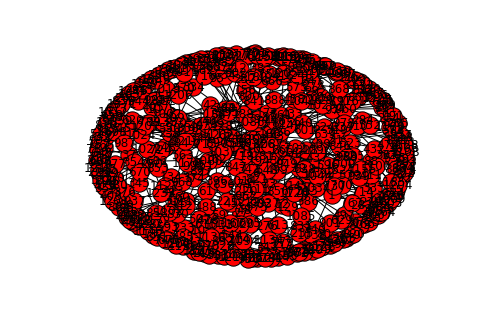

In [145]:
nx.draw(H,with_labels=True)

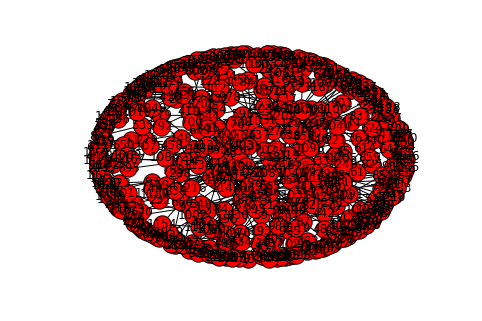

In [147]:
nx.draw(rand_H,with_labels=True)

average cc:0.036699511747
average cc:0.036699511747


In [149]:
H==rand_H

True

# scramble

In [ ]:
#check if two nodes are connected
import networkx as nx
G=nx.Graph()
G.add_edge('a','b',weight=1)
G.add_edge('a','c',weight=1)
G.add_edge('c','d',weight=1)

print(G.has_edge('a','d'))  # False
print('d' in G['a']) # False, faster
print(not 'd' in G['a']) # True

In [138]:
H[1041].keys()

[273, 575, 188, 237, 561]

In [140]:
from random import choice
choice(H[1041].keys())

575